# Linear regressions on spiracle data with a phylogenetic covariance matrix via MCMC

To begin with, we need to import necessary python packages.

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api
import scipy.stats

import bokeh.io
import bokeh.plotting

from Bio import Phylo
import io

import cmdstanpy
import arviz as az

import bebi103
import re

import plotting_utils

import logging

bokeh.io.output_notebook()

Loading BokehJS ...

We can now read in the data into a dataframe for analyis.

In [2]:
df = pd.read_csv("./20190322_supp_table_2.csv")

We take a look at the format for the data.

In [3]:
df['species_underscore'] = [spec.replace(" ", "_") for  spec in df['species']]
df.head()

Unnamed: 0   subfamily                 species sex  mass (g) spiracle  \
0           0  Cetoniinae     Goliathus goliathus   M    16.280        6   
1           1  Cetoniinae     Goliathus goliathus   F    18.150        6   
2           2  Cetoniinae   Coelorrhina hornimani   M     1.130        6   
3           3  Cetoniinae  Dicronorrhina derbyana   M     2.120        6   
4           4  Cetoniinae  Dicronorrhina derbyana   F     2.145        6   

   area (mm^2)  depth (mm)      species_underscore  
0     0.274408    2.512648     Goliathus_goliathus  
1     0.134949    1.606189     Goliathus_goliathus  
2     0.212131    0.553833   Coelorrhina_hornimani  
3     0.039532    0.473369  Dicronorrhina_derbyana  
4     0.049701    0.496320  Dicronorrhina_derbyana

For some of this analysis, we will look at the per-species averages for our measurements. To get this, we use a simple aggregate function on the dataframe and take a look at the results.

In [4]:
df_averages = df.groupby(['species', 'species_underscore', 'spiracle'], as_index=False).aggregate(np.average)
df_averages['subfamily'] = df.groupby(['species', 'species_underscore', 'spiracle'], as_index=False).aggregate(max)['subfamily']
df_averages.head()

species     species_underscore spiracle  Unnamed: 0  \
0  Coelorrhina hornimani  Coelorrhina_hornimani        1        87.0   
1  Coelorrhina hornimani  Coelorrhina_hornimani        2        70.0   
2  Coelorrhina hornimani  Coelorrhina_hornimani        3        53.0   
3  Coelorrhina hornimani  Coelorrhina_hornimani        4        36.0   
4  Coelorrhina hornimani  Coelorrhina_hornimani        5        19.0   

   area (mm^2)  depth (mm)  mass (g)   subfamily  
0     0.135347    0.416717      1.13  Cetoniinae  
1     0.084207    0.451409      1.13  Cetoniinae  
2     0.106693    0.325444      1.13  Cetoniinae  
3     0.115574    0.481558      1.13  Cetoniinae  
4     0.119145    0.506751      1.13  Cetoniinae

Let's take a look at the number of species per subfamily in the data.

In [5]:
species_per_subfam=df_averages.groupby(['subfamily', 'spiracle'], as_index=False).count().groupby('subfamily').aggregate(max).reset_index()[['subfamily', 'species']]
species_per_subfam.columns = ('subfamily', 'subfam_count')
species_per_subfam

subfamily  subfam_count
0  Cetoniinae             6
1  Dynastinae             3
2   Rutelinae             1

In [6]:
df_averages = df_averages.merge(species_per_subfam, on='subfamily')

For our plots, we will log transform the data. We will add a column to the dataframe with the log transformed data. We will also need some transforms of our data, which we will do here.

In [7]:
df_averages['log area (mm^2)'] = np.log10(df_averages['area (mm^2)'])
df_averages['log dist'] = np.log10(df_averages['depth (mm)'])
df_averages['log mass (g)'] = np.log10(df_averages['mass (g)'])
df_averages['log area/dist'] = np.log10(df_averages['area (mm^2)']/df_averages['depth (mm)'])
df_averages['log area^2/dist'] = np.log10(df_averages['area (mm^2)']**2/df_averages['depth (mm)'])

df_averages.head()

species     species_underscore spiracle  Unnamed: 0  \
0  Coelorrhina hornimani  Coelorrhina_hornimani        1        87.0   
1  Coelorrhina hornimani  Coelorrhina_hornimani        2        70.0   
2  Coelorrhina hornimani  Coelorrhina_hornimani        3        53.0   
3  Coelorrhina hornimani  Coelorrhina_hornimani        4        36.0   
4  Coelorrhina hornimani  Coelorrhina_hornimani        5        19.0   

   area (mm^2)  depth (mm)  mass (g)   subfamily  subfam_count  \
0     0.135347    0.416717      1.13  Cetoniinae             6   
1     0.084207    0.451409      1.13  Cetoniinae             6   
2     0.106693    0.325444      1.13  Cetoniinae             6   
3     0.115574    0.481558      1.13  Cetoniinae             6   
4     0.119145    0.506751      1.13  Cetoniinae             6   

   log area (mm^2)  log dist  log mass (g)  log area/dist  log area^2/dist  
0        -0.868551 -0.380159      0.053078      -0.488392        -1.356943  
1        -1.074651 -0.345430      0.053078      -0.729221        -1.803872  
2        -0.971862 -0.487524      0.053078      -0.484339        -1.456201  
3        -0.937142 -0.317351      0.053078      -0.619790        -1.556932  
4        -0.923923 -0.295205      0.053078      -0.628717        -1.552640

In addition to log transforming the species averaged data, we will do the same for the whole data set.

In [8]:
df['log area (mm^2)'] = np.log10(df['area (mm^2)'])
df['log dist'] = np.log10(df['depth (mm)'])
df['log mass (g)'] = np.log10(df['mass (g)'])
df['log area/dist'] = np.log10(df['area (mm^2)']/df['depth (mm)'])
df['log area^2/dist'] = np.log10(df['area (mm^2)']**2/df['depth (mm)'])
df.head()

Unnamed: 0   subfamily                 species sex  mass (g) spiracle  \
0           0  Cetoniinae     Goliathus goliathus   M    16.280        6   
1           1  Cetoniinae     Goliathus goliathus   F    18.150        6   
2           2  Cetoniinae   Coelorrhina hornimani   M     1.130        6   
3           3  Cetoniinae  Dicronorrhina derbyana   M     2.120        6   
4           4  Cetoniinae  Dicronorrhina derbyana   F     2.145        6   

   area (mm^2)  depth (mm)      species_underscore  log area (mm^2)  log dist  \
0     0.274408    2.512648     Goliathus_goliathus        -0.561603  0.400132   
1     0.134949    1.606189     Goliathus_goliathus        -0.869831  0.205797   
2     0.212131    0.553833   Coelorrhina_hornimani        -0.673395 -0.256621   
3     0.039532    0.473369  Dicronorrhina_derbyana        -1.403054 -0.324800   
4     0.049701    0.496320  Dicronorrhina_derbyana        -1.303635 -0.304238   

   log mass (g)  log area/dist  log area^2/dist  
0      1.211654      -0.961735        -1.523338  
1      1.258877      -1.075628        -1.945459  
2      0.053078      -0.416774        -1.090169  
3      0.326336      -1.078254        -2.481309  
4      0.331427      -0.999397        -2.303033

In order to perform a regression that incorporates phylogenetic non-independence of our data, we will need a phylogeny for our species. The tree below is taken from [here](https://julianmwagner.github.io/spiracle_scaling/studydesign/study_design.html), and is constructed based on a few beetle trees. Note that the branch lengths are set to $1$, one option for data where the branch lengths are not known, though we will consider this structure for the data in our model later.

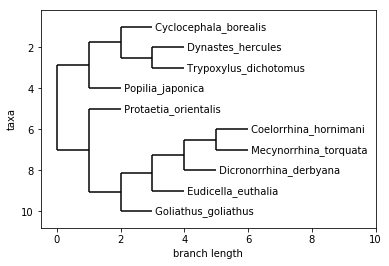

In [9]:
tree = Phylo.read(io.StringIO("(((Cyclocephala_borealis:1.0,(Dynastes_hercules:1.0,Trypoxylus_dichotomus:1.0):1.0):1.0,Popilia_japonica:1.0):1.0,(Protaetia_orientalis:1.0,((((Coelorrhina_hornimani:1.0,Mecynorrhina_torquata:1.0):1,Dicronorrhina_derbyana:1):1,Eudicella_euthalia:1.0):1,Goliathus_goliathus:1.0):1.0):1.0):0.0;"),
          "newick")

Phylo.draw(tree, xlim=(-0.5, 10))

With this tree in hand, we can now construct the covariance matrix given by the tree. The way that we do this is per [here](https://doi.org/10.1007/978-3-662-43550-2_5) where the the expected covariance of two species morphological measurements is given by the amount of shared ancestry of the taxa. We can implement this by calculating the total branch lengths from the most recent common ancestor of two species to the root of the tree.

In [10]:
species = df.sort_values('mass (g)')['species_underscore'].unique()

cov = np.zeros(shape=(len(species), len(species)))
comp_matrix = np.zeros(shape=(len(species), len(species))).astype(str)

for i, spec in enumerate(species):
    for j, comp in enumerate(species):
        if i == j:
            cov[i, j] = 6.0
            #continue
        cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
        
        comp_matrix[i, j] = spec[0:spec.find('_')] + ":" + comp[0:comp.find('_')] + ":" + str(int(cov[i, j]))
print("\n")
print("Covariance matrix:")
print(cov.astype(int))
print("\n\n")
print("Species comparisons for the covariance matrix:")
pd.DataFrame(comp_matrix)



Covariance matrix:
[[3 1 0 0 0 0 2 0 0 2]
 [1 2 0 0 0 0 1 0 0 1]
 [0 0 2 1 1 1 0 1 1 0]
 [0 0 1 6 3 4 0 5 2 0]
 [0 0 1 3 4 3 0 3 2 0]
 [0 0 1 4 3 5 0 4 2 0]
 [2 1 0 0 0 0 4 0 0 3]
 [0 0 1 5 3 4 0 6 2 0]
 [0 0 1 2 2 2 0 2 3 0]
 [2 1 0 0 0 0 3 0 0 4]]



Species comparisons for the covariance matrix:


0                        1  \
0   Cyclocephala:Cyclocephala:3   Cyclocephala:Popilia:1   
1        Popilia:Cyclocephala:1        Popilia:Popilia:2   
2      Protaetia:Cyclocephala:0      Protaetia:Popilia:0   
3    Coelorrhina:Cyclocephala:0    Coelorrhina:Popilia:0   
4      Eudicella:Cyclocephala:0      Eudicella:Popilia:0   
5  Dicronorrhina:Cyclocephala:0  Dicronorrhina:Popilia:0   
6     Trypoxylus:Cyclocephala:2     Trypoxylus:Popilia:1   
7   Mecynorrhina:Cyclocephala:0   Mecynorrhina:Popilia:0   
8      Goliathus:Cyclocephala:0      Goliathus:Popilia:0   
9       Dynastes:Cyclocephala:2       Dynastes:Popilia:1   

                           2                            3  \
0   Cyclocephala:Protaetia:0   Cyclocephala:Coelorrhina:0   
1        Popilia:Protaetia:0        Popilia:Coelorrhina:0   
2      Protaetia:Protaetia:2      Protaetia:Coelorrhina:1   
3    Coelorrhina:Protaetia:1    Coelorrhina:Coelorrhina:6   
4      Eudicella:Protaetia:1      Eudicella:Coelorrhina:3   
5  Dicronorrhina:Protaetia:1  Dicronorrhina:Coelorrhina:4   
6     Trypoxylus:Protaetia:0     Trypoxylus:Coelorrhina:0   
7   Mecynorrhina:Protaetia:1   Mecynorrhina:Coelorrhina:5   
8      Goliathus:Protaetia:1      Goliathus:Coelorrhina:2   
9       Dynastes:Protaetia:0       Dynastes:Coelorrhina:0   

                           4                              5  \
0   Cyclocephala:Eudicella:0   Cyclocephala:Dicronorrhina:0   
1        Popilia:Eudicella:0        Popilia:Dicronorrhina:0   
2      Protaetia:Eudicella:1      Protaetia:Dicronorrhina:1   
3    Coelorrhina:Eudicella:3    Coelorrhina:Dicronorrhina:4   
4      Eudicella:Eudicella:4      Eudicella:Dicronorrhina:3   
5  Dicronorrhina:Eudicella:3  Dicronorrhina:Dicronorrhina:5   
6     Trypoxylus:Eudicella:0     Trypoxylus:Dicronorrhina:0   
7   Mecynorrhina:Eudicella:3   Mecynorrhina:Dicronorrhina:4   
8      Goliathus:Eudicella:2      Goliathus:Dicronorrhina:2   
9       Dynastes:Eudicella:0       Dynastes:Dicronorrhina:0   

                            6                             7  \
0   Cyclocephala:Trypoxylus:2   Cyclocephala:Mecynorrhina:0   
1        Popilia:Trypoxylus:1        Popilia:Mecynorrhina:0   
2      Protaetia:Trypoxylus:0      Protaetia:Mecynorrhina:1   
3    Coelorrhina:Trypoxylus:0    Coelorrhina:Mecynorrhina:5   
4      Eudicella:Trypoxylus:0      Eudicella:Mecynorrhina:3   
5  Dicronorrhina:Trypoxylus:0  Dicronorrhina:Mecynorrhina:4   
6     Trypoxylus:Trypoxylus:4     Trypoxylus:Mecynorrhina:0   
7   Mecynorrhina:Trypoxylus:0   Mecynorrhina:Mecynorrhina:6   
8      Goliathus:Trypoxylus:0      Goliathus:Mecynorrhina:2   
9       Dynastes:Trypoxylus:3       Dynastes:Mecynorrhina:0   

                           8                         9  
0   Cyclocephala:Goliathus:0   Cyclocephala:Dynastes:2  
1        Popilia:Goliathus:0        Popilia:Dynastes:1  
2      Protaetia:Goliathus:1      Protaetia:Dynastes:0  
3    Coelorrhina:Goliathus:2    Coelorrhina:Dynastes:0  
4      Eudicella:Goliathus:2      Eudicella:Dynastes:0  
5  Dicronorrhina:Goliathus:2  Dicronorrhina:Dynastes:0  
6     Trypoxylus:Goliathus:0     Trypoxylus:Dynastes:3  
7   Mecynorrhina:Goliathus:2   Mecynorrhina:Dynastes:0  
8      Goliathus:Goliathus:3      Goliathus:Dynastes:0  
9       Dynastes:Goliathus:0       Dynastes:Dynastes:4

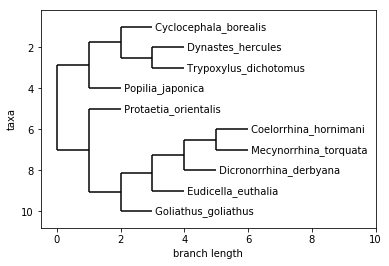

In [11]:
Phylo.draw(tree, xlim=(-0.5, 10))

With our data in this format, we can build the PGLS model for our regression. To do this, we will write a statistical model for the data. We choose a multivariate normal distribution with covariance matrix given by the above matrix adjusted by the parameter $\lambda$ (as in PGLS), and put a prior on $\lambda$. We also incorporate a $\sigma$ term to scale the diagonal terms of the covariance matrix, since the branch lengths to a given species in a tree with unit branch length does not provide a biologically meaningful insight into the degree of variation in the scaling relationship. The $\sigma$ parameter allows the data to inform how dispersed the data is from the given trend line. This gives

\begin{align}
f(x_i; a, b) &= ax_i + b \\
f_\sigma(\mathrm{cov}, \lambda, \sigma) &=  \lambda*\text{cov-off-diagonal-terms}, \sigma*\text{cov-diagonal-terms}\\
b &\sim \text{Norm}(-1, 2) \\
a &\sim \text{Norm}(\mathrm{isometry}, 0.3)\\ [\mathrm{isometry_{area}=2/3, \, isometry_{depth}=1/3},& \, \mathrm{isometry_{area/depth}}=1/3, \, \mathrm{isometry_{area^2/depth}}=1]\\
\lambda &\sim \text{beta}(1.4, 1.4) \\
\sigma &\sim \mathrm{HalfNorm}(0, 1) \\
y_i &\sim \text{multi_normal}\left(f_\mu(x_i; a, b), f_\sigma(\mathrm{cov}, \lambda, \sigma)\right)
\end{align}


Time for a prior predictive check on our model! The code for the model is

```
functions {
  real f(real x_i, real a, real b) {
    real y_i = x_i*a + b;
    return y_i;
  }
}

data {
  int<lower=1> N;
  vector[N] x;
  real a_mu;
  real a_sig;
  real b_mu;
  real b_sig;
  real lambda_alpha;
  real lambda_beta;
  matrix[N, N] cov_phylo;
}

generated quantities {
  // Data
  vector[N] y;
  matrix[N, N] cov;
  vector[N] mu;
  
  real a = normal_rng(a_mu, a_sig);
  real b = normal_rng(b_mu, b_sig);
  real lambda = beta_rng(lambda_alpha, lambda_beta);
  
  for (i in 1:N) {
    for (j in 1:N) {
      if (! i == j)
        cov[i, j] = cov_phylo[i,j]*lambda;
     else
     cov[i, j] = cov_phylo[i,j];
    }
  }
  
  
  for (i in 1:N) {
    mu[i] = f(x[i], a, b);
  }
  
  y = multi_normal_rng(mu, cov);
}
```

We compile the model:

In [12]:
sm_prior_pred = cmdstanpy.CmdStanModel(
    stan_file="spiracle_pgls_prior_predictive.stan"
)

INFO:cmdstanpy:stan to c++ (C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_prior_predictive.hpp)
INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: C:/Users/jwagne/git/spiracle_scaling/spiracle_pgls_prior_predictive.exe


With the model compiled, we sample.

In [13]:
x = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == '1', 'log mass (g)'].values

data = {
    "N": len(x),
    "x": x,
    "a_mu": 0.66,
    "a_sig": 0.3,
    "b_mu": -1.0,
    "b_sig": 1.0,
    "lambda_alpha": 1.1,
    "lambda_beta": 1.1,
    "cov_phylo":cov,
}

samples = sm_prior_pred.sample(data=data, sampling_iters=1000, fixed_param=True)
samples = az.from_cmdstanpy(posterior=samples, prior=samples, prior_predictive=['y'])

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


We take a look at the results for our prior predictive check.

In [14]:
bokeh.io.show(
    
    bebi103.viz.predictive_regression(
        samples.prior_predictive['y'],
        samples_x=x,
        percentiles=[30, 60, 90, 99],
        x_axis_label='mass',
        y_axis_label='area',
    )
)

This looks good! Basically, we just want to ensure that the priors take into account some of our domain expertise/existing knowledge (e.g. morphological structure probably scale with positive slope, though this is not a guarantee, so we put our prior peaked at a positive value, but sufficiently broad as to still allow for the remote possibility that we were wrong about a positive slope, in which case the data will overwhelm the prior and allow use to learn the true parameter value). This plot shows that our priors allow for a lot of potential regression lines and will let our data inform the parameters. We can also implement a similar check directly in python. We draw 1,000 datasets from our generative model (using just the phylogenetic covariance, no lambda or sigma terms).

In [15]:
size = 1000
lines = [a*x+b+sample for a, b, sample in zip(np.random.normal(0.66,0.33, size=size), np.random.normal(-1,2,size=size),
                                              np.random.multivariate_normal(x, cov, size=size))]#+np.random.normal(0, 3, size=(100,) ))]
p = bokeh.plotting.figure(plot_height=300)
[p.line(x, y, alpha=0.2) for y in lines]
bokeh.io.show(p)

Looks good! Now that we defined our model based on our prior information, we can take a look at what some of our actual data looks like.

In [16]:
p = bokeh.plotting.figure(plot_height=300)
p.circle('log mass (g)', 'log area (mm^2)', source=df_averages.loc[df_averages['spiracle'] == '1'])
bokeh.io.show(p)

Seems like our prior predictive distribution would certainly be able to generate data that looks like this, which is a good sign!

As another check and to make sure that we have a good sense of what exactly the phylogenetically determined covariance matrix means with regard to the model, we will plot the prior predictive values for pairs of species against each other. The covariance term means that some of these plots will look like independent normal distributions (e.g. a blob with no skew to it), whereas taxa that share ancestry will have a skewed distribution. That is, related taxa have covariance such that if the value for one species is large, it is more likely that the other species will also have a large value. We iterate through our prior predictive samples and make such comparison plots.

In [17]:
plots = []
sample = np.random.multivariate_normal(x, cov, size=1000)
specs = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == '1', 'species'].values
num = df_averages.sort_values('mass (g)').loc[df_averages.sort_values('mass (g)')['spiracle']=='1', 'subfam_count'].values
for i in range(len(sample[0])):
    for j in range(len(sample[0]))[i:-1]:
        p = bokeh.plotting.figure(plot_width=200, plot_height=200, #x_range=(-5, 5), y_range=(-5, 5),
                                  x_axis_label=specs[i], y_axis_label=specs[j],title='Covariance')
        p.circle(sample[:, i], sample[:, j], alpha=0.1)
        plots.append(p)

Before we plot these, we once again display the phylogeny so we can look at the taxa relationships as compared to the distributions. 

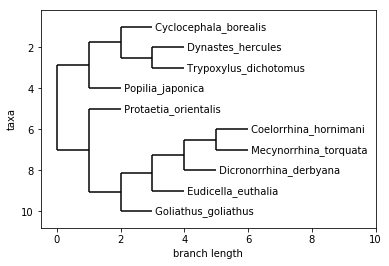

In [18]:
Phylo.draw(tree, xlim=(-0.5, 10))

In [19]:
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=4))

These look good! We can see that species that share less branch length (are more distantly related to each other) have little/no covariance whereas species closer in the tree do vary together. With these checks done, we now will sample our model. The Stan code for the model is as follows:

```
functions {
  real f(real x_i, real a, real b) {
    real y_i = x_i*a + b;
    return y_i;
  }
}

data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
  real priora;
  matrix[N, N] cov_phylo;
}

parameters {
  real a;
  real b;
  real<lower=0, upper=1> lambda;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu;
  matrix[N, N] cov;
  
  for (i in 1:N) {
    mu[i] = f(x[i], a, b);
  }
  
  for (i in 1:N) {
    for (j in 1:N) {
      if (! i == j)
        cov[i, j] = cov_phylo[i,j]*lambda;//*sigma;
      else
        cov[i, j] = cov_phylo[i,j]*sigma;
    }
  }
  
}

model {
  a ~ normal(priora, 0.3);
  b ~ normal(-1.0, 2.0);
  //lambda ~ beta(10.0, 0.5);
  
  sigma ~ normal(0.0, 1.0);
  lambda ~ beta(1.4, 1.4);
  y ~ multi_normal(mu, cov);
  
}

generated quantities {
  vector[N] y_ppc;
  vector[N] mu_ppc;
  real coef_var = (sigma)/(10^b);

  for (i in 1:N) {
    mu_ppc[i] = f(x[i], a, b);
  }
  
  y_ppc = multi_normal_rng(mu_ppc, cov);
  
}
```

With this compiled, we can now sample for each morphological variable in our data! We also generate some plots that we will look at after sampling, and run diagnostics to check that the sampling proceeded smoothly.

In [20]:
all_summaries = {}
all_regressions = {}
lambda_plots = []
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
for morphs, iso in zip(['log area (mm^2)', 'log dist', 'log area/dist', 'log area^2/dist'], [0.67, 0.33, 0.33, 1.0]):

    sigmas = []
    slopes = []
    intercepts = []
    summaries = {}
    plots = []
    for spir in ['S', 'T', '1', '2', '3', '4', '5', '6']:
        x = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == spir, 'log mass (g)'].values
        y = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == spir, morphs].values
        x_ppc = x.copy()
        data = {
            "N": len(x),
            "x": x,
            "y": y,
            "priora": iso,
            "cov_phylo":cov,
        }

        sm = cmdstanpy.CmdStanModel(stan_file='spiracle_pgls_model.stan')

        samples = sm.sample(data=data, sampling_iters=1000, chains=4)

        samples = az.from_cmdstanpy(posterior=samples, posterior_predictive=["y_ppc"])
        
        p = bebi103.viz.corner(samples, pars=["a", "b", "lambda", "sigma"]).children[1].children[5][0]
        p.line(np.linspace(0, 1, 200), scipy.stats.beta.pdf(np.linspace(0, 1, 200), 1.4, 1.4), line_width=8, alpha=0.5)
        p.title.text = 'Spiracle ' + spir + ' ' + morphs
        p.width = 300
        p.height = 200
        p.xaxis.major_label_text_font_size = '8pt'
        p.yaxis.major_label_text_font_size = '8pt'
        p.xaxis.axis_label = 'λ parameter value'
        p.yaxis.axis_label = 'Probability density'
        lambda_plots.append(p)
        bebi103.stan.check_all_diagnostics(samples, var_names=['b', 'a', 'sigma', 'lambda'])
        sigmas.append(samples.posterior['sigma'].values.ravel())
        slopes.append(samples.posterior['a'].values.ravel())
        intercepts.append(samples.posterior['b'].values.ravel())
        summaries[spir] = az.summary(samples, var_names=['b', 'a', 'sigma', 'coef_var'])
        summaries[spir]['median'] = [np.median(samples.posterior['b'].values.ravel()),
                                     np.median(samples.posterior['a'].values.ravel()),
                                     np.median(samples.posterior['sigma'].values.ravel()),
                                     np.median(samples.posterior['coef_var'].values.ravel())]
        plots.append(plotting_utils.plot_regression_comparison(df, df_averages, x, spir, morphs, samples, iso, x_ppc, circle_size=9, line_width=1, circle_alpha=1, width=225, height=225))
    all_summaries[morphs] = summaries
    all_regressions[morphs] = plots
logging.getLogger("cmdstanpy").setLevel(logging.INFO)

Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.
Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.
Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.
Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum t

The sampling looks to have gone well! We will not take a look at the prior plot for the $\lambda$ parameter and compare it to the samples that we generated for this parameter. If we are informing this parameter with our data, we expect to see shrinkage, i.e. the posterior samples will be narrower and more peaked than the prior.

In [21]:
bokeh.io.show(bokeh.layouts.gridplot(lambda_plots, ncols=4))

Oof! For every model that we sampled, the prior and posterior look almost identical. This indicates that the $\lambda$ parameter is non-identifiable, that is, the data does not inform this parameter. This suggests that including the phylogenetic covariance in our model is not aiding our analyis. We comment out the code below used to save out these plots to SVGs.

In [22]:
#TO SAVE LAMBDA SAMPLE PLOTS
#for p in lambda_plots:
#    t = p.title.text
#    t = re.sub(re.compile('\s|\(|\)|\^|/'), '_', t)
#    t = re.sub('__', '_', t)
#    t = re.sub('_$', '', t)
#    p.output_backend = 'svg'
#    bokeh.io.export_svgs(p, filename='C:/Users/jwagne/Downloads/'+t+'.svg')

We will now plot some summary statistics about the samples we have acquired for each model.

In [23]:
plots = []
for morphs, iso, heading in zip(['log area (mm^2)', 'log dist', 'log area/dist', 'log area^2/dist'], [0.67, 0.33, 0.33, 1.0], ['Area', 'Depth', 'Diffusive', 'Advective']):
    #print(morphs)
    summaries = all_summaries[morphs]
    for var, yax, var_title in zip(['a', 'b', 'sigma', 'coef_var'], ['log-log slope', 'intercept (mm^2)', 'log-log sigma', 'σ/10^b'], ['slope', 'intercept', 'variance', 'σ/10^b']):
        p = bokeh.plotting.figure(plot_height=200, plot_width=300, x_range=['S', 'T', '1', '2', '3', '4', '5', '6'], title=heading + ', Median ± HPD for ' + var_title, y_axis_label=yax, x_axis_label='Spiracle')#, y_axis_type='log')
        #p = bokeh.plotting.figure(plot_height=200, plot_width=300, x_range=['S', 'T', '1', '2', '3', '4', '5', '6'])
        p.xaxis.visible = False
        p.outline_line_color = None
        p.yaxis.minor_tick_line_color = None
        p.xaxis.minor_tick_line_color = None
        if var == 'a':
                p.line([-10, 100], [iso, iso], color='black', line_width=2, line_alpha=1)
        for i, spir in enumerate(['S', 'T', '1', '2', '3', '4', '5', '6']):
            CI_a, CI_b, CI_σ, CI_co_σ, slope, intercept, σ, co_σ = plotting_utils.make_CIs(df_averages, morphs, spir)
            
            if var == 'b':
                c = 1
                if morphs == 'log area/dist':
                    c = 0.178*404*(1/10)
                elif morphs == 'log area^2/dist':
                    c = (1/(3.1415*8*1.86*(10**(-8))))*(0.1**3)
                p.line([spir, spir], c*(10**np.array([summaries[spir].loc[var]['hpd_3%'], summaries[spir].loc[var]['hpd_97%']])), color='grey', line_width=7, alpha=0.75)
                p.line([spir, spir], c*(10**CI_b), color='black', line_width=2, alpha=0.75)
                p.diamond([spir,],   c*(10**summaries[spir].loc[var]['median']), color='white', size=9, alpha=1)
                p.diamond([spir,],   c*(10**intercept), color='black', size=5)
            elif var == 'a':
                p.line([spir, spir], [summaries[spir].loc[var]['hpd_3%'], summaries[spir].loc[var]['hpd_97%']], color='grey', line_width=7, alpha=0.75)
                p.line([spir, spir], CI_a, color='black', line_width=2, alpha=0.75)
                p.diamond([spir,], summaries[spir].loc[var]['median'], color='white', size=9, alpha=1)
                p.diamond([spir,], slope, color='black', size=5)
            elif var == 'sigma':
                p.line([spir, spir], [np.mean(cov.diagonal())*summaries[spir].loc[var]['hpd_3%'], np.mean(cov.diagonal())*summaries[spir].loc[var]['hpd_97%']], color='grey', line_width=7, alpha=0.75)
                p.line([spir, spir], CI_σ, color='black', line_width=2, alpha=0.75)
                p.diamond([spir,], np.mean(cov.diagonal())*summaries[spir].loc[var]['median'], color='white', size=9, alpha=1)
                p.diamond([spir,], σ, color='black', size=5)
                
            elif var == 'coef_var':
                p.line([spir, spir], [np.mean(cov.diagonal())*summaries[spir].loc[var]['hpd_3%'], np.mean(cov.diagonal())*summaries[spir].loc[var]['hpd_97%']], color='grey', line_width=7, alpha=0.75)
                p.line([spir, spir], CI_co_σ, color='black', line_width=2, alpha=0.75)
                p.diamond([spir,], np.mean(cov.diagonal())*summaries[spir].loc[var]['median'], color='white', size=9, alpha=1)
                p.diamond([spir,], co_σ, color='black', size=5)

        p.xgrid.grid_line_color = None
        #p.ygrid.grid_line_color = None
        p.output_backend = 'svg'
        plots.append(p)
        #bokeh.io.show(p)
        
print("FOR ALL PLOTS: White diamond is median Bayesian parameter sample, grey box is 3%-97% highest posterior density interval for parameter samples")
print("FOR ALL PLOTS: Black diamond is median summary statistic for non-parametric bootstrapping on OLS, black line is 2.5%-97.5% percentile for bootstrapped summary stat\n")
print('Area regressions (log-log slope, intercept (mm^2), log-log σ)')
bokeh.io.show(bokeh.layouts.gridplot(plots[0:4], ncols=2))
print('Depth regressions (log-log slope, intercept (mm), log-log σ)')
bokeh.io.show(bokeh.layouts.gridplot(plots[4:8], ncols=2))
print('Area/Depth regressions (log-log slope, intercept (G_diff), log-log σ)')
bokeh.io.show(bokeh.layouts.gridplot(plots[8:12], ncols=2))
print('Area^2/Depth regressions (log-log slope, intercept (G_adv), log-log σ)')
bokeh.io.show(bokeh.layouts.gridplot(plots[12:16], ncols=2))

#print('Area regressions (log-log slope, intercept (mm^2), log-log σ)')
#bokeh.io.show(bokeh.layouts.gridplot(plots[0:3], ncols=3))
#print('Depth regressions (log-log slope, intercept (mm), log-log σ)')
#bokeh.io.show(bokeh.layouts.gridplot(plots[3:6], ncols=3))
#print('Area/Depth regressions (log-log slope, intercept (G_diff), log-log σ)')
#bokeh.io.show(bokeh.layouts.gridplot(plots[6:9], ncols=3))
#print('Area^2/Depth regressions (log-log slope, intercept (G_adv), log-log σ)')
#bokeh.io.show(bokeh.layouts.gridplot(plots[9:12], ncols=3))

FOR ALL PLOTS: White diamond is median Bayesian parameter sample, grey box is 3%-97% highest posterior density interval for parameter samples
FOR ALL PLOTS: Black diamond is median summary statistic for non-parametric bootstrapping on OLS, black line is 2.5%-97.5% percentile for bootstrapped summary stat

Area regressions (log-log slope, intercept (mm^2), log-log σ)


Depth regressions (log-log slope, intercept (mm), log-log σ)


Area/Depth regressions (log-log slope, intercept (G_diff), log-log σ)


Area^2/Depth regressions (log-log slope, intercept (G_adv), log-log σ)


Notice that (especially for the variance estimates) the phylogenetic model suggests more uncertainty about the parameter estimates than a non-parametric bootstrapping approach. This may be due to the under-constrained $\lambda$ parameter together with the covariance matrix of the model (which is too rigidly informed by the semi-arbitrary branch lengths of the tree) causing the model to over-estimate the degree of variance in the data. As a final check both that our model worked and what results it produced, we will plot the posterior predictive regression for the Bayesian models as well as regressions with confidence intervals on the slopes/intercepts generated via non-parametric bootstrapping. Note that for all of these plots the grey ranges show the range of regression output values (either from sampling or bootstrapping) at the 2.5th-97.5th percentiles. Central line is the 45th-55th percentile range for Bayesian regression values, or the OLS line with non-resampled data for the the bootstrap regression plots. The two grey regions for the Bayesian regressions are the 95th and 80th percentile ranges for the posterior predictive distribution for the model. The black dots are the measured data points. 

## Plot for species averaged mass vs species averaged spiracle area (log transformed)

In [24]:
print("Bayesian phylogenetic regression:")
bokeh.io.show(bokeh.layouts.gridplot(all_regressions['log area (mm^2)'], ncols=4))
print("Non-parametric bootstrapping:")
b_plots = plotting_utils.make_plot(df_averages, 'log area (mm^2)', 2/3, width=225, height=225, point_size=9)

Bayesian phylogenetic regression:


Non-parametric bootstrapping:


## Species averaged mass vs species averaged spiracle depth (log transformed)

In [25]:
print("Bayesian phylogenetic regression:")
bokeh.io.show(bokeh.layouts.gridplot(all_regressions['log dist'], ncols=4))
print("Non-parametric bootstrapping:")
b_plots = plotting_utils.make_plot(df_averages, 'log dist', 1/3, width=225, height=225, point_size=9)

Bayesian phylogenetic regression:


Non-parametric bootstrapping:


---

## Species averaged mass vs $\frac{\mathrm{species\,averaged\,area}}{\mathrm{species\,averaged\,depth}}$ (log transformed)

In [26]:
print("Bayesian phylogenetic regression:")
bokeh.io.show(bokeh.layouts.gridplot(all_regressions['log area/dist'], ncols=4))
print("Non-parametric bootstrapping:")
b_plots = plotting_utils.make_plot(df_averages, 'log area/dist', 1/3, width=225, height=225, point_size=9)

Bayesian phylogenetic regression:


Non-parametric bootstrapping:


---

## Species averaged mass vs $\frac{(\mathrm{species\,averaged\,area})^2}{\mathrm{species\,averaged\,depth}}$ (log transformed)

In [27]:
print("Bayesian phylogenetic regression:")
bokeh.io.show(bokeh.layouts.gridplot(all_regressions['log area^2/dist'], ncols=4))
print("Non-parametric bootstrapping:")
b_plots = plotting_utils.make_plot(df_averages, 'log area^2/dist', 1, width=225, height=225, point_size=9)

Bayesian phylogenetic regression:


Non-parametric bootstrapping:


These look pretty similar! The Bayesian regression once again looks like it may be overestimating uncertainty, possibly for the reasons mentioned before.

In [28]:
%reload_ext watermark
%watermark -p bokeh,cmdstanpy

bokeh 1.4.0
cmdstanpy 0.8.0
